In [7]:
import pickle
import numpy as np
from scipy.special import logsumexp

import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# generate binary input vector
def simulate_single_input(time, Dv):
    inputs = np.zeros((time, Dv))
    
    number_of_non_zero_dimenions = np.random.choice([7,8,9,10,11,12], 1)[0]
    
    non_zero_dimensions = np.random.choice(Dv, number_of_non_zero_dimenions)
    
    for k in non_zero_dimensions:
        start = np.random.choice(time-1, 1)[0]
        end = start + 1 +  np.random.choice(time-1-start ,1)[0]
        inputs[start:end, k] = np.ones(end-start)
    return inputs
    

In [30]:
def simulate_clv_with_inputs(A, Wa, g, Wg, N, inputs):
    """Simulates data under compositional Lotka-Volterra.
        
        Let p = (p_1, ..., p_D) be the relative proportions
        of D taxa (species).

        Let x = alr(p), the additive log-ratio of p. Note 
        x is in R^{D-1} (log-space) and p is in S^D (simplex).

        The state space model is:
            x_t ~ Normal(f(x_{t-1} + g + Ap_{t-1}, input_{t-1}), e
        
        The observation model is:
            y_t ~ Multinomial(C_t, p_t = alr^{-1}(x_t))

        The count parameter C_t is chosen to simulate the
        varying sequencing depths observed across real samples.


    Parameters
    ----------
        ntaxa  : number of species to simulate
        ndays  : number of days to simulate
        ss_var : state space variance

    Returns
    -------
        x  : an ndays by ntaxa-1 matrix of latent states
        y  : an ndays by ntaxa matrix of observed sequencing counts
        A  : simulated interaction matrix A in R^{D-1 x D}
        g  : simulated growth rate vector g in R^{D-1}
        mu : initial mean

    """
    latent_dim = A.shape[0]
    ndays, input_dim = inputs.shape
    
    x = []
    y_count = []
    y_percentage = []
    
    # modify the mu
    mu  = np.random.multivariate_normal(mean=np.zeros(latent_dim), cov=np.eye(latent_dim))
    for t in range(ndays):
        xt = mu

        # increase dimension by 1
        xt1 = np.concatenate((xt, np.array([0])))
        pt = np.exp(xt1 - logsumexp(xt1))

        # simulate total number of reads with over-dispersion
        logN = np.random.normal(loc=np.log(N), scale=0.5)
        Nt = np.random.poisson(np.exp(logN))
        yt_count = np.random.multinomial(Nt, pt).astype(float)
        yt_percentage = yt_count / np.sum(yt_count)

        x.append(xt)
        y_count.append(yt_count)
        y_percentage.append(yt_percentage)

        transition_noise = np.random.multivariate_normal(mean=np.zeros(latent_dim), cov=0.1 * np.eye(latent_dim))
        vt = inputs[t]

        # Wg: (Dx, Dv), Wa: (Dx, Dv)
        mu = xt + g + Wg.dot(vt) + (A + Wa.dot(vt)[:,None]).dot(pt)
    return np.array(x), np.array(y_count), np.array(y_percentage)

In [31]:
ntaxa = 11
ninput = 15
ndays = 30
n_train, n_test = 17, 4
A = np.random.normal(loc=1, scale=0.2, size=(ntaxa-1, ntaxa))
Wa = np.random.normal(loc=5, scale=0.2, size=(ntaxa-1, ninput))
g = np.random.normal(loc=0.5, scale=0.1, size=ntaxa-1)
Wg = np.random.normal(loc=6, scale=0.1, size=(ntaxa-1, ninput))
N = 10000 # sequencing reads parameter

In [32]:
list_of_ndays = [42, 47, 29, 23, 29, 35, 58, 28, 31, 33, 20, 32, 26, 50, 25, 43, 25, 38, 27, 25, 26]

In [33]:
batch_inputs = [simulate_single_input(100, ninput) for _ in range(n_train+n_test)]

In [34]:
# create data with missing observation
x_train = []
x_test = []
y_count_train = []
y_count_test = []
y_percentage_train = []
y_percentage_test = []
v_train = []
v_test = []
days = np.arange(ndays)[:, np.newaxis]
for i in range(n_train + n_test):
    x, y_count, y_percentage = simulate_clv_with_inputs(A, Wa, g, Wg, N, batch_inputs[i])
    
    # select days
    ndays = list_of_ndays[i]
    start = np.random.choice(100 - list_of_ndays[i], 1)[0]
    end = start + ndays
    # make missing observations, the first day cannot be missing
    obs_percentage = np.random.choice([0.4,0.5,0.6,0.7,0.8], p=[0.1,0.2,0.2,0.2,0.3])
    obsed_days = np.random.choice(np.arange(1, ndays), int(ndays * obs_percentage), replace=False)
    obsed_days = np.sort(np.concatenate(([0],obsed_days)))
    
    y_percentage = y_percentage[obsed_days]
    x = x[obsed_days]
    y_count = y_count[obsed_days]
    
    days = np.arange(ndays)[:, np.newaxis]
    y_count = np.concatenate([days[obsed_days], y_count], axis=-1)
    y_percentage = np.concatenate([days[obsed_days], y_percentage], axis=-1)
    v = np.concatenate([days, batch_inputs[i][start:end]], axis=-1)
    if i < n_train:
        x_train.append(x)
        y_count_train.append(y_count)
        y_percentage_train.append(y_percentage)
        v_train.append(v)
    else:
        x_test.append(x)
        y_count_test.append(y_count)
        y_percentage_test.append(y_percentage)
        v_test.append(v)

In [35]:
p_data = {}
p_data["Xtrain"] = x_train
p_data["Xtest"] = x_test
p_data["Ytrain"] = y_percentage_train
p_data["Ytest"] = y_percentage_test
p_data["Vtrain"] = v_train
p_data["Vtest"] = v_test


In [36]:
extra_inputs_train = [None for _ in range(len(y_percentage_train))]
extra_inputs_test = [None for _ in range(len(y_percentage_test))]

In [37]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test = x_train, x_test, y_percentage_train, y_percentage_test, v_train, v_test

In [38]:
import sys
sys.path.append("/Users/leah/Columbia/courses/19summer/microbialdynamics")

In [39]:
from src.utils.data_interpolation import interpolate_data

In [40]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test, _mask_train, _mask_test, time_interval_train, time_interval_test, extra_inputs_train, extra_input_test = \
                interpolate_data(hidden_train, hidden_test, obs_train, obs_test, input_train, input_test,
                                 extra_inputs_train, extra_inputs_test, False)


masks = _mask_train + _mask_test
obs = obs_train + obs_test
inputs = input_train + input_test

In [41]:
def bar_plot(ax, obs, mask, to_normalize=True,):
    if to_normalize:
            obs = obs / np.sum(obs, axis=-1, keepdims=True)

    time, Dy = obs.shape

    # make missing obs = 0
    masked_obs = np.zeros_like(obs)
    masked_obs[mask] = obs[mask]
    
    ax.set_xlabel("Time")
    bottom = np.zeros(time)
    for j in range(Dy):
        ax.bar(np.arange(time), masked_obs[:, j], bottom=bottom, edgecolor='white')
        bottom += masked_obs[:, j]

    ax.set_xticks(np.arange(time))
    sns.despine()
    

def input_plot(ax, inputs):
    time, Dv = inputs.shape
    
    for j in range(Dv):
        has_inputs = inputs[:,j]== 1
        idx = np.arange(time)[has_inputs]
        ax.bar(idx, [1 for _ in idx], bottom=[j for _ in idx], color='blue')
    
    ax.set_xticks(np.arange(time))
    ax.set_yticks(np.arange(Dv))
    sns.despine()
        

In [42]:
def plot_inputs_and_obs(i):
    plt.figure(figsize=(15,10))

    ax1= plt.subplot(2,1,1)
    input_plot(ax1, inputs[i])
    ax1.grid()

    ax2 = plt.subplot(2,1,2, sharex = ax1)
    bar_plot(ax2, obs[i], masks[i])
    ax2.grid()

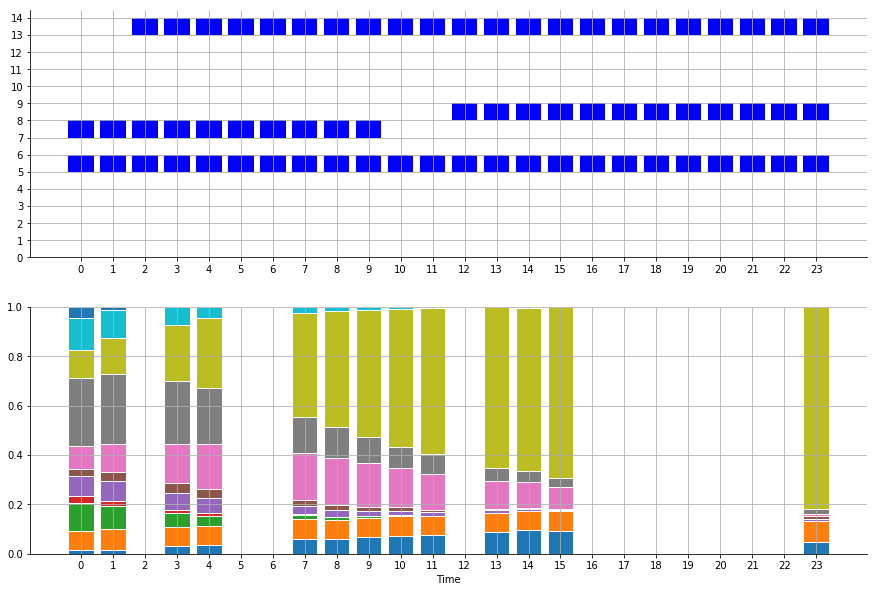

In [46]:
plot_inputs_and_obs(16)